In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
# plotly maps
import plotly.express as px
import plotly.figure_factory as ff
from urllib.request import urlopen
import json
# sys.path.append(os.path.abspath("C:/Users/Alex/Documents/My Data Files/COVID Research/analysis/mention_2_hashtag.py"))

# from analysis.functions.mention_2_hashtag import * 
# from analysis.functions.datamanip import *

raw = pd.read_csv('flair.joined.tweets.csv')

# changing date to more readable format
raw['created_at'] = pd.to_datetime(raw['created_at'])

# getting seperated date and time columns
raw['date'] = raw['created_at'].dt.date
raw['time'] = raw['created_at'].dt.time
raw['hour'] = raw['created_at'].dt.hour

# changing na to None
raw = raw.fillna('None')

raw = raw[raw['sentiment'] != 'None']

raw['is_negative'] = [1 if 'NEGATIVE' in str(sent) else 0 for sent in raw['sentiment']]
raw['is_positive'] = [1 if 'POSITIVE' in str(sent) else 0 for sent in raw['sentiment']]


def convert_fips(unknown_fips_list, fin):
    
    def convert(fipsline):
        name, postal, fips= fipsline.strip().split('\t')

        return {fips: name}

    fips_dict = {f: n 
                for dic in [convert(line)for line in open(fin, 'r')]
                for f, n in dic.items()}

    return [fips_dict[f'{unknown:02d}'] for unknown in unknown_fips_list]

raw = raw[raw['statefips'] != 'None']

raw['state_name'] = convert_fips([int(float(fips)) for fips in raw['statefips']],
                     '../analysis/functions/state.fips.txt')

raw['fips'] = [f'{int(float(state)):02d}{int(float(county)):03d}' for i, state, county in raw[['statefips', 'countyfips']].itertuples()]
raw['count'] = 1
raw.head()

id_str                created_at  follower_count  \
0  id:1226763665036075008 2020-02-10 07:03:44+00:00           270.0   
1  id:1226763937317818368 2020-02-10 07:04:49+00:00           199.0   
2  id:1226764107958734851 2020-02-10 07:05:30+00:00           235.0   
3  id:1226765442548719616 2020-02-10 07:10:48+00:00         60008.0   
4  id:1226765540229861376 2020-02-10 07:11:11+00:00         60008.0   

   friends_count statefips countyfips countyname  is_urban  \
0          539.0      32.0        3.0      Clark         1   
1          216.0      36.0       81.0     Queens         1   
2          130.0       4.0       13.0   Maricopa         1   
3        51176.0       5.0      119.0    Pulaski         0   
4        51176.0       5.0      119.0    Pulaski         0   

                                              ogtext  \
0  having a mocha and avoiding coronavirus at the...   
1                         our hearts beat with china   
2  people stop my sister in the street to make fu...   
3   coronavirus death toll surpasses the number o...   
4   coronavirus cases aboard japanese cruise ship...   

                                           cleantext  ... sentiment  \
0               have mocha avoid coronavirus airport  ...  POSITIVE   
1                                   heart beat china  ...  POSITIVE   
2  people stop sister street fun wearing mask s a...  ...  POSITIVE   
3     coronavirus death toll surpass number fatal...  ...  NEGATIVE   
4     coronavirus case aboard japanese cruise shi...  ...  NEGATIVE   

  sent_confidence        date      time hour is_negative is_positive  \
0        0.940228  2020-02-10  07:03:44    7           0           1   
1        0.872616  2020-02-10  07:04:49    7           0           1   
2        0.925717  2020-02-10  07:05:30    7           0           1   
3        0.994157  2020-02-10  07:10:48    7           1           0   
4        0.998726  2020-02-10  07:11:11    7           1           0   

  state_name   fips  count  
0     Nevada  32003      1  
1   New York  36081      1  
2    Arizona  04013      1  
3   Arkansas  05119      1  
4   Arkansas  05119      1  

[5 rows x 24 columns]

California, New York, Texas, and Florida had the most tweets

# States - number of tweets, proportion of sentiment, comparison of urban/rural

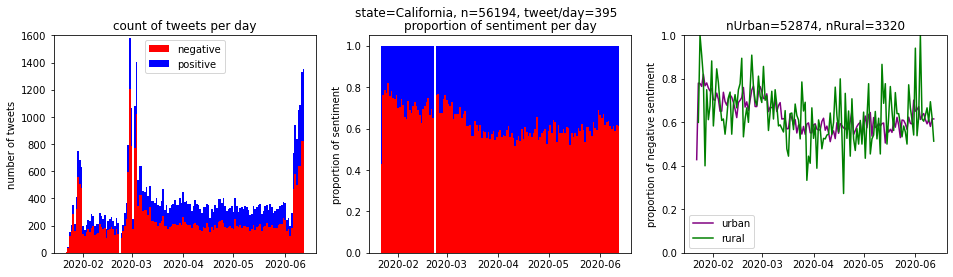

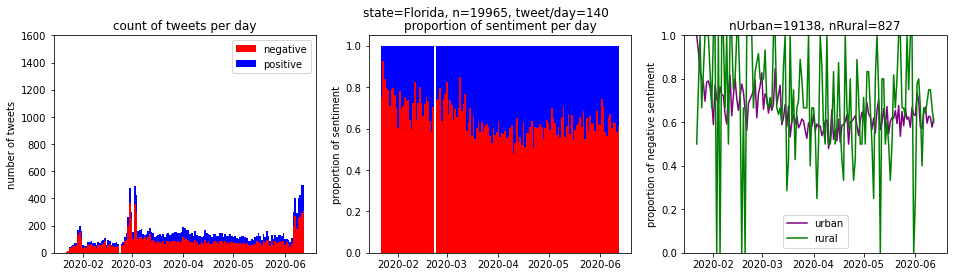

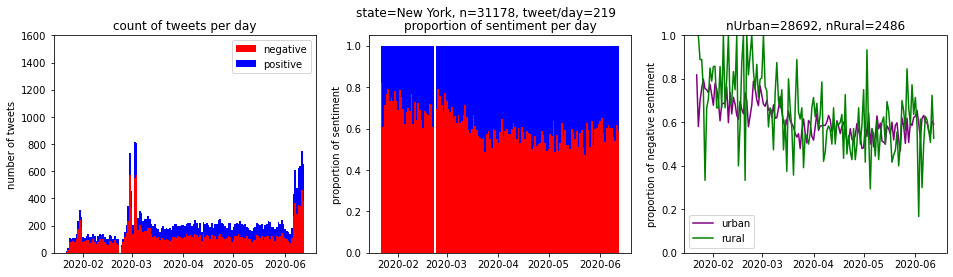

In [41]:
states = ['California', 'New York', 'Texas', 'Florida']
top_states = raw[raw['state_name'].isin(states)]
top_states = top_states.groupby(['state_name', 'is_urban', 'date']).agg({'is_negative':'mean', 'count':'count'}).reset_index()

for state, df in top_states.groupby(['state_name']):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 4), sharex=True) #sharey = True

    ndf = raw[raw['state_name'] == state].groupby(['state_name', 'date']).agg({'is_negative':'mean', 'count':'count'}).reset_index()

    ndf['is_positive'] = 1 - ndf['is_negative']
    ndf['total'] = 1
    ndf['nnegative'] = ndf['count'] * ndf['is_negative']
    ndf['npositive'] = ndf['count'] - ndf['nnegative']
    sum = ndf['count'].sum()
    avg = ndf['count'].mean()
    urban = df[df['is_urban'] == 1]
    rural = df[df['is_urban'] == 0]

    ax[0].bar(ndf.date, ndf.nnegative, color= 'r', label='negative',width=1.0)
    ax[0].bar(ndf.date, ndf.npositive, bottom = ndf.nnegative, color = 'b', label='positive',width=1.0)
    ax[0].set_ylabel('number of tweets')
    ax[0].set_title(f'count of tweets per day')
    ax[0].set_ylim(0,1600)
    ax[0].legend()

    ax[1].bar(ndf.date, ndf.is_negative, color= 'r', label='negative',width=1.0)
    ax[1].bar(ndf.date, ndf.is_positive, bottom = ndf.is_negative, color = 'b', label='positive',width=1.0)
    ax[1].set_ylabel('proportion of sentiment')
    ax[1].set_title(f'proportion of sentiment per day')
    # ax[1].legend()

    ax[2].plot(urban.date, urban.is_negative, color = 'purple', label= 'urban')
    ax[2].plot(rural.date, rural.is_negative, color = 'g', label= 'rural')
    ax[2].set_ylabel('proportion of negative sentiment')
    ax[2].set_title(f'nUrban={urban["count"].sum()}, nRural={rural["count"].sum()}')
    ax[2].set_ylim(0,1)
    ax[2].legend()

    fig.suptitle(f'state={state}, n={sum}, tweet/day={int(avg)}')

    plt.show()

# Topics - number of tweets, proportion of sentiment, comparison of rural / urban

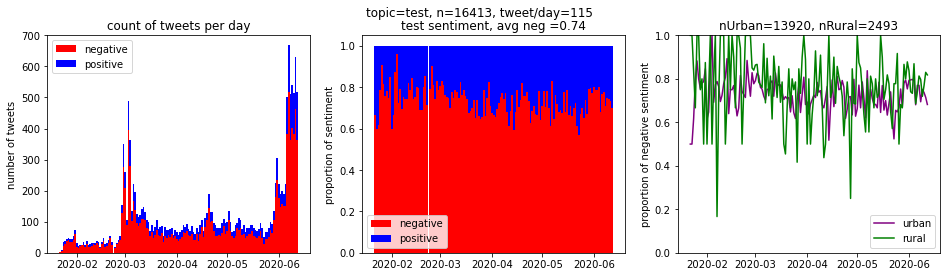

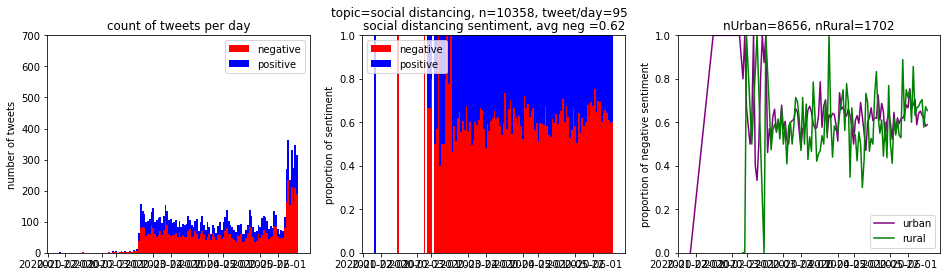

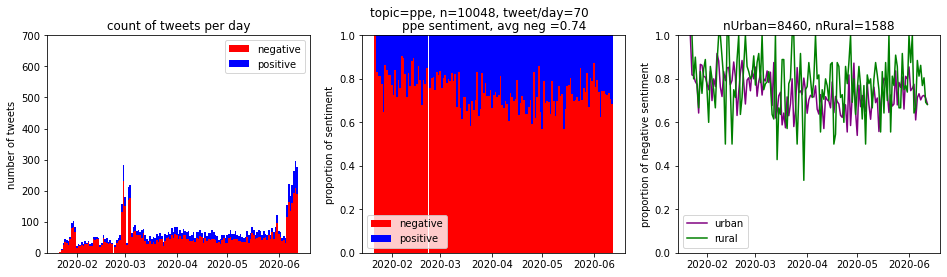

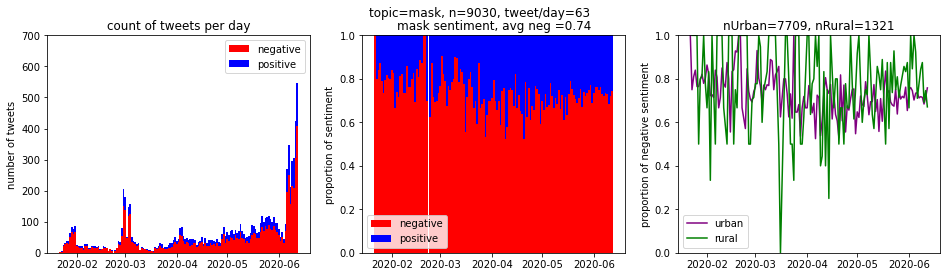

In [43]:
topics = ['test', "social distancing", 'ppe', "mask", "stay home"]

for i, topic in enumerate(topics):
    raw[topic] = [1 if topic in text else 0 for text in raw['ogtext']]

for topic in topics:
    topic_urban_df = raw[raw[topic] == 1].groupby(['is_urban', 'date']).agg({'is_negative':'mean', 'count':'count'}).reset_index()

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 4), sharex=True) #sharey = True

    urban = topic_urban_df[topic_urban_df['is_urban'] == 1]
    rural = topic_urban_df[topic_urban_df['is_urban'] == 0]

    topic_df = raw[raw[topic] == 1].groupby(['date']).agg({'is_negative':'mean', 'count':'count'}).reset_index()

    topic_df['nnegative'] = topic_df['count'] * topic_df['is_negative']
    topic_df['npositive'] = topic_df['count'] - topic_df['nnegative']
    sum = topic_df['count'].sum()
    avg = topic_df['count'].mean()
    topic_df['is_positive'] = 1 - topic_df['is_negative']
    topic_df['total'] = 1
    avg_neg = round(topic_df['is_negative'].mean(),2)


    ax[0].bar(topic_df.date, topic_df.nnegative, color= 'r', label='negative',width=1.0)
    ax[0].bar(topic_df.date, topic_df.npositive, bottom = topic_df.nnegative, color = 'b', label='positive',width=1.0)
    ax[0].set_ylabel('number of tweets')
    ax[0].set_title(f'count of tweets per day')
    ax[0].set_ylim(0,700)
    ax[0].legend()


    ax[1].bar(topic_df.date, topic_df.is_negative, color= 'r', label='negative',width=1.0)
    ax[1].bar(topic_df.date, topic_df.is_positive, bottom = topic_df.is_negative, color = 'b', label='positive',width=1.0)
    ax[1].set_ylabel('proportion of sentiment')
    ax[1].set_title(f'{topic} sentiment, avg neg ={avg_neg}')
    ax[1].legend()


    ax[2].plot(urban.date, urban.is_negative, color = 'purple', label= 'urban')
    ax[2].plot(rural.date, rural.is_negative, color = 'g', label= 'rural')
    ax[2].set_ylabel('proportion of negative sentiment')
    ax[2].set_title(f'nUrban={urban["count"].sum()}, nRural={rural["count"].sum()}')
    ax[2].set_ylim(0,1)
    ax[2].legend()

    fig.suptitle(f'topic={topic}, n={sum}, tweet/day={int(avg)}')
    plt.show()

# Topics - by state - number of tweets, proportion of sentiment

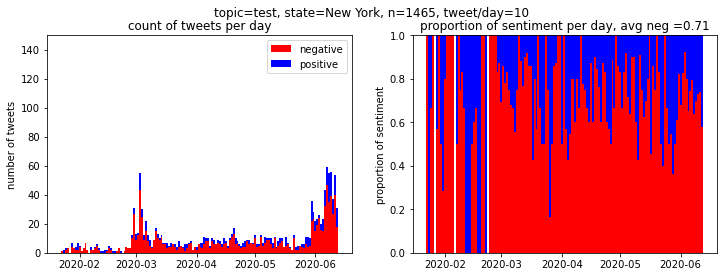

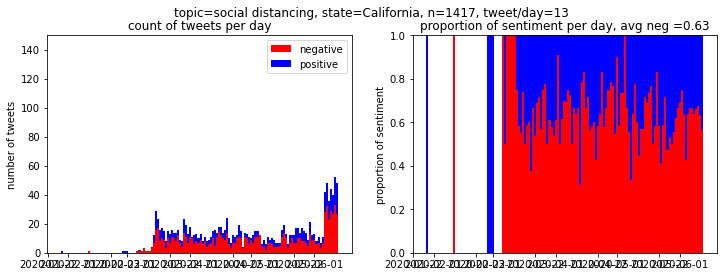

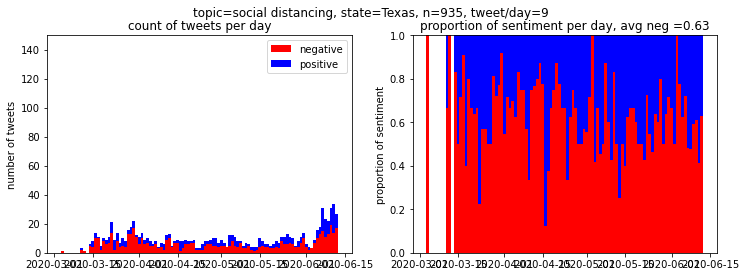

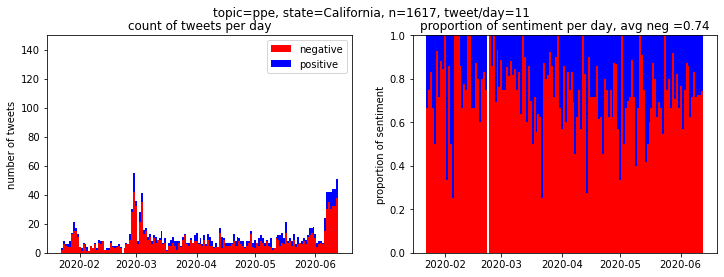

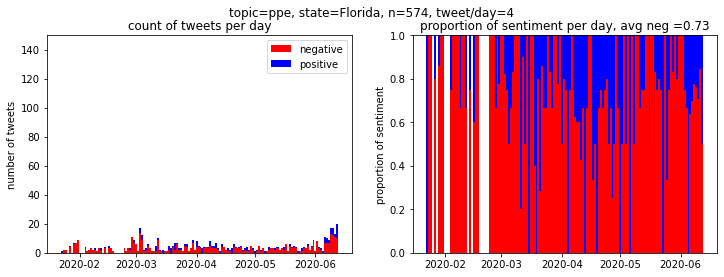

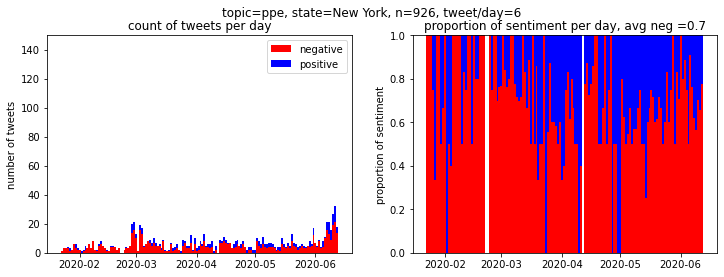

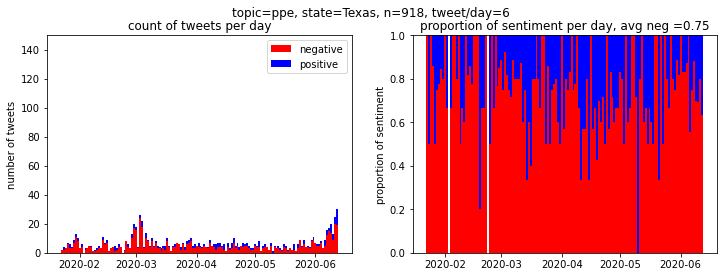

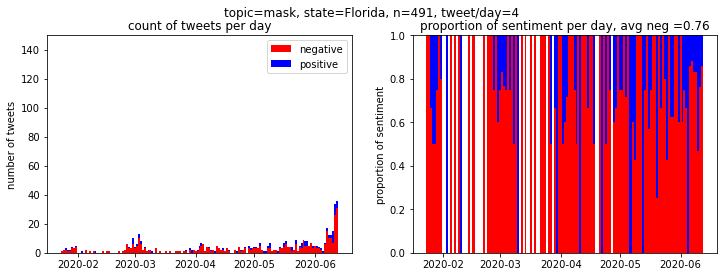

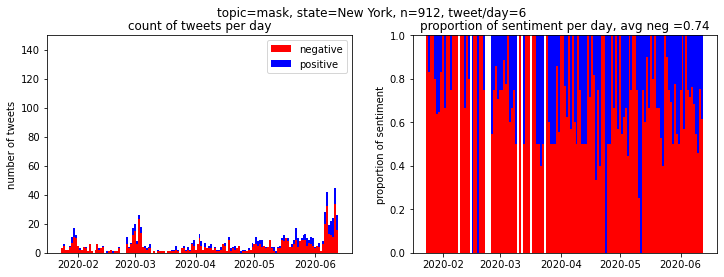

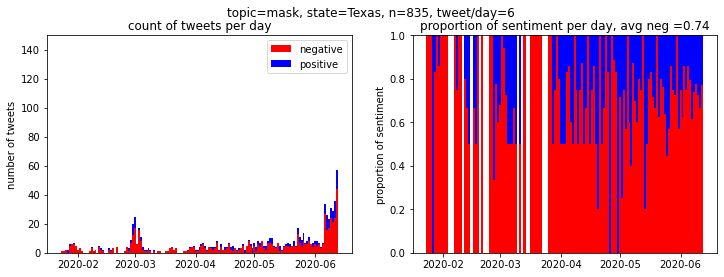

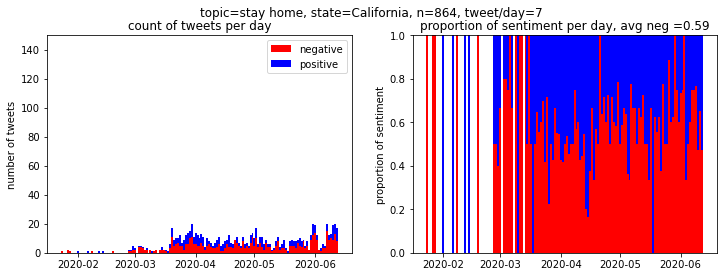

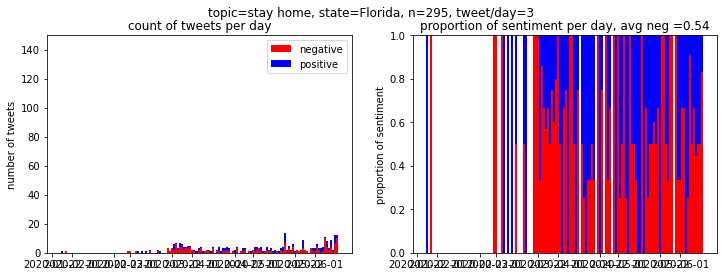

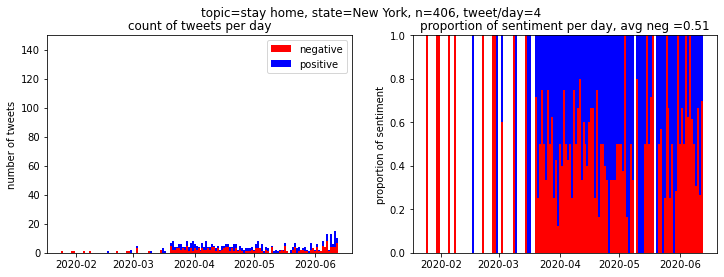

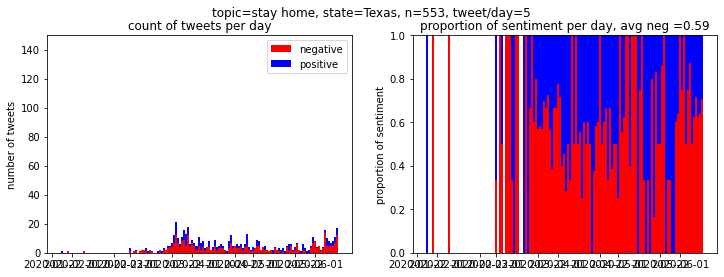

In [42]:
topics = ['test', "social distancing", 'ppe', "mask", "stay home"]
states = ['California', 'New York', 'Texas', 'Florida']
top_states = raw[raw['state_name'].isin(states)]

for i, topic in enumerate(topics):
    top_states[topic] = [1 if topic in text else 0 for text in top_states['ogtext']]

for i, topic in enumerate(topics):
    topic_state = top_states.groupby(['state_name', topic, 'date']).agg({'is_negative':'mean', 'count':'count'}).reset_index()
    topic_state = topic_state[topic_state[topic] == 1]
    
    for state, df in topic_state.groupby(['state_name']):

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharex=True) #sharey = True

        df['is_positive'] = 1 - df['is_negative']
        df['total'] = 1
        df['nnegative'] = df['count'] * df['is_negative']
        df['npositive'] = df['count'] - df['nnegative']
        sum = df['count'].sum()
        avg = df['count'].mean()
        avg_neg = round(df['is_negative'].mean(),2)
        # urban = df[df['is_urban'] == 1]
        # rural = df[df['is_urban'] == 0]

        ax[0].bar(df.date, df.nnegative, color= 'r', label='negative',width=1.0)
        ax[0].bar(df.date, df.npositive, bottom = df.nnegative, color = 'b', label='positive',width=1.0)
        ax[0].set_ylabel('number of tweets')
        ax[0].set_title(f'count of tweets per day')
        ax[0].set_ylim(0,150)
        ax[0].legend()

        ax[1].bar(df.date, df.is_negative, color= 'r', label='negative',width=1.0)
        ax[1].bar(df.date, df.is_positive, bottom = df.is_negative, color = 'b', label='positive',width=1.0)
        ax[1].set_ylabel('proportion of sentiment')
        ax[1].set_title(f'proportion of sentiment per day, avg neg ={avg_neg}')
        # ax[1].legend()


        fig.suptitle(f'topic={topic}, state={state}, n={sum}, tweet/day={int(avg)}')
        plt.show()
    
